In [1]:
from src.test_non_local_switching_model import load_data

is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)


In [2]:
from scipy.ndimage import gaussian_filter1d
import numpy as np


def gaussian_smooth(data, sigma, sampling_frequency, axis=0, truncate=8):
    """1D convolution of the data with a Gaussian.
    The standard deviation of the gaussian is in the units of the sampling
    frequency. The function is just a wrapper around scipy's
    `gaussian_filter1d`, The support is truncated at 8 by default, instead
    of 4 in `gaussian_filter1d`
    Parameters
    ----------
    data : array_like
    sigma : float
    sampling_frequency : int
    axis : int, optional
    truncate : int, optional
    Returns
    -------
    smoothed_data : array_like
    """
    return gaussian_filter1d(
        data, sigma * sampling_frequency, truncate=truncate, axis=axis, mode="constant"
    )


def estimate_low_spike_times(
    spikes,
    speed=None,
    sampling_frequency=500,
    sigma=0.015,
    rate_threshold=0.010,
    speed_threshold=4.0,
):
    spike_rate = gaussian_smooth(
        spikes.sum(axis=1), sigma=sigma, sampling_frequency=sampling_frequency
    )
    is_low_spike = spike_rate < rate_threshold

    if speed is not None:
        is_low_speed = speed < speed_threshold
    else:
        is_low_speed = np.ones_like(spike_rate, dtype=bool)

    return np.logical_and(is_low_spike, is_low_speed)


8855

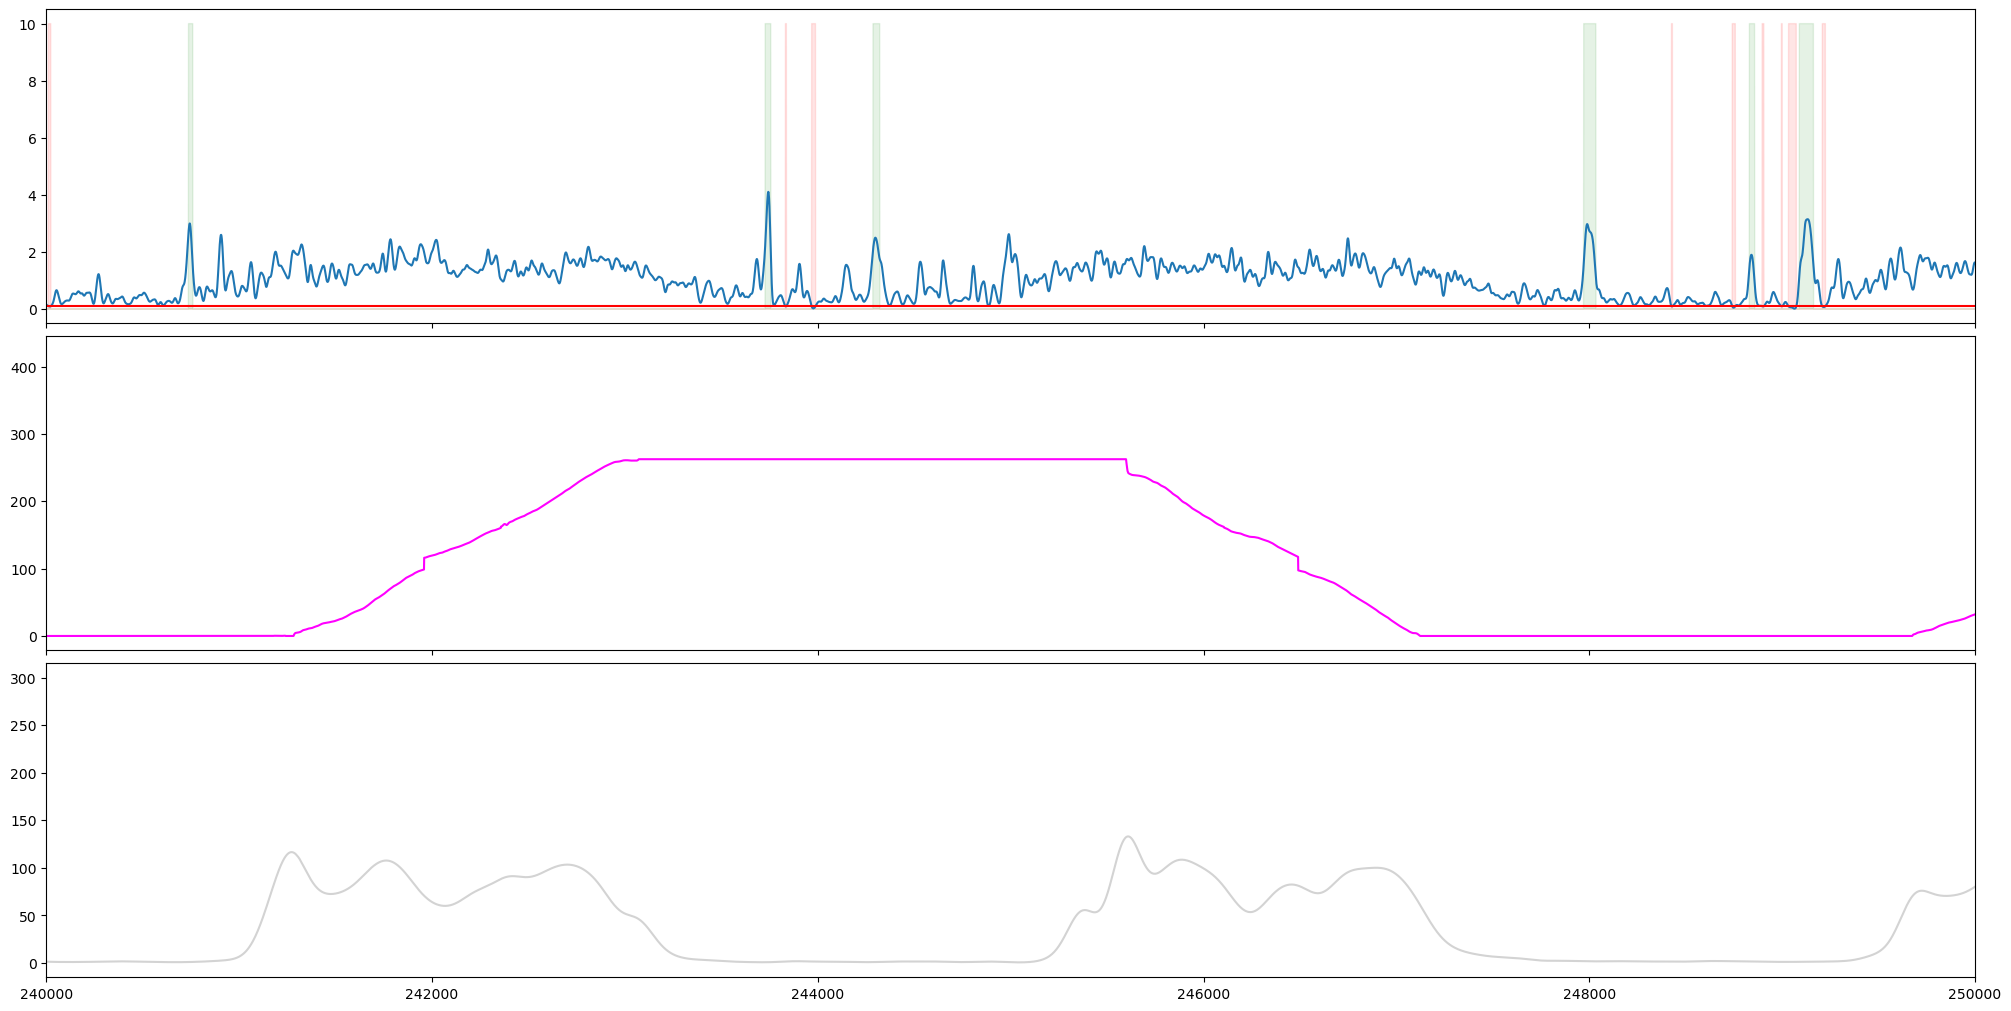

In [3]:
import matplotlib.pyplot as plt

rate_threshold = 0.1
sigma = 0.015

is_low_spike_time = estimate_low_spike_times(
    spikes, speed, rate_threshold=rate_threshold, sigma=sigma
)
spike_rate = gaussian_smooth(spikes.sum(axis=1), sigma=sigma, sampling_frequency=500)

fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, constrained_layout=True)
axes[0].plot(spike_rate)
axes[0].fill_between(
    np.arange(len(is_low_spike_time)), is_low_spike_time * 10.0, color="red", alpha=0.1
)
axes[0].fill_between(
    np.arange(len(is_low_spike_time)), is_ripple * 10.0, color="green", alpha=0.1
)
axes[0].axhline(rate_threshold, color="red")


axes[1].plot(position, color="magenta")

axes[2].plot(speed, color="lightgrey")

plt.xlim((240_000, 250_000))

is_low_spike_time.sum()


In [7]:
is_local_time = np.logical_and(~is_ripple, ~is_low_spike_time)


In [101]:
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.stattools import lagmat
from patsy import dmatrix


def estimate_initial_stationary_discrete_transition(
    is_ripple, spikes, speed=None, rate_threshold=0.1, sigma=0.015
):

    is_low_spike_time = estimate_low_spike_times(
        spikes, speed, rate_threshold=rate_threshold, sigma=sigma
    )
    is_local_time = np.logical_and(~is_ripple, ~is_low_spike_time)

    response = np.zeros_like(is_local_time, dtype=int)
    response[is_local_time] = 0
    response[is_low_spike_time] = 1
    response[is_ripple] = 2

    data = {
        "local": lagmat(is_local_time, maxlag=1),
        "no_spike": lagmat(is_low_spike_time, maxlag=1),
        "non_local": lagmat(is_ripple, maxlag=1),
    }
    predict_matrix = np.array([1])[:, np.newaxis]

    state_transition = []
    coef = []

    for from_state in [
        "local",
        "no_spike",
        "non_local",
    ]:
        design_matrix = dmatrix(f"{from_state} - 1", data)
        model = LogisticRegression(fit_intercept=False).fit(design_matrix, response)
        state_transition.append(model.predict_proba(predict_matrix).squeeze())
        coef.append(model.coef_.T)

    return np.stack(state_transition), np.stack(coef, axis=1)


st, c = estimate_initial_stationary_discrete_transition(is_ripple, spikes, speed)
c.shape


(1, 3, 3)

In [103]:
def estimate_initial_non_stationary_discrete_transition(
    is_ripple, spikes, speed, rate_threshold=0.1, sigma=0.015
):

    is_low_spike_time = estimate_low_spike_times(
        spikes, speed, rate_threshold=rate_threshold, sigma=sigma
    )
    is_local_time = np.logical_and(~is_ripple, ~is_low_spike_time)

    response = np.zeros_like(is_local_time, dtype=int)
    response[is_local_time] = 0
    response[is_low_spike_time] = 1
    response[is_ripple] = 2

    data = {
        "local": lagmat(is_local_time, maxlag=1),
        "no_spike": lagmat(is_low_spike_time, maxlag=1),
        "non_local": lagmat(is_ripple, maxlag=1),
        "speed": lagmat(speed, maxlag=1),
    }

    state_names = ["local", "no_spike", "non_local"]
    speed_knots = [1.0, 2.0, 3.0, 10.0, 50.0, 75.0]

    n_states = 3
    n_time = speed.shape[0]
    coef = []
    state_transition = np.zeros((n_time, n_states, n_states))

    for state_ind, from_state in enumerate(state_names):
        formula = (
            f"1 + {from_state} * "
            f"cr(speed, knots={speed_knots}, constraints='center')"
        )
        design_matrix = dmatrix(formula, data)
        model = LogisticRegression(fit_intercept=False).fit(design_matrix, response)

        state_transition[:, state_ind, :] = model.predict_proba(design_matrix).squeeze()
        coef.append(model.coef_.T)

    coef = np.stack(coef, axis=1)

    return state_transition, coef


In [104]:
coef.shape


(16, 3, 3)

(0.0, 10000.0)

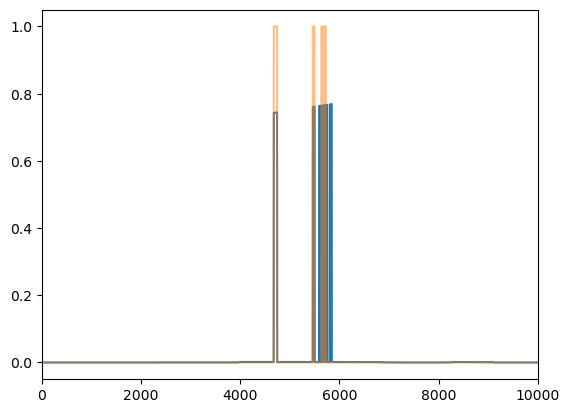

In [115]:
plt.plot(state_transition[:, 0, 2])
plt.plot(is_ripple, alpha=0.5)
plt.xlim((0, 10_000))


NameError: name 'state_transition' is not defined

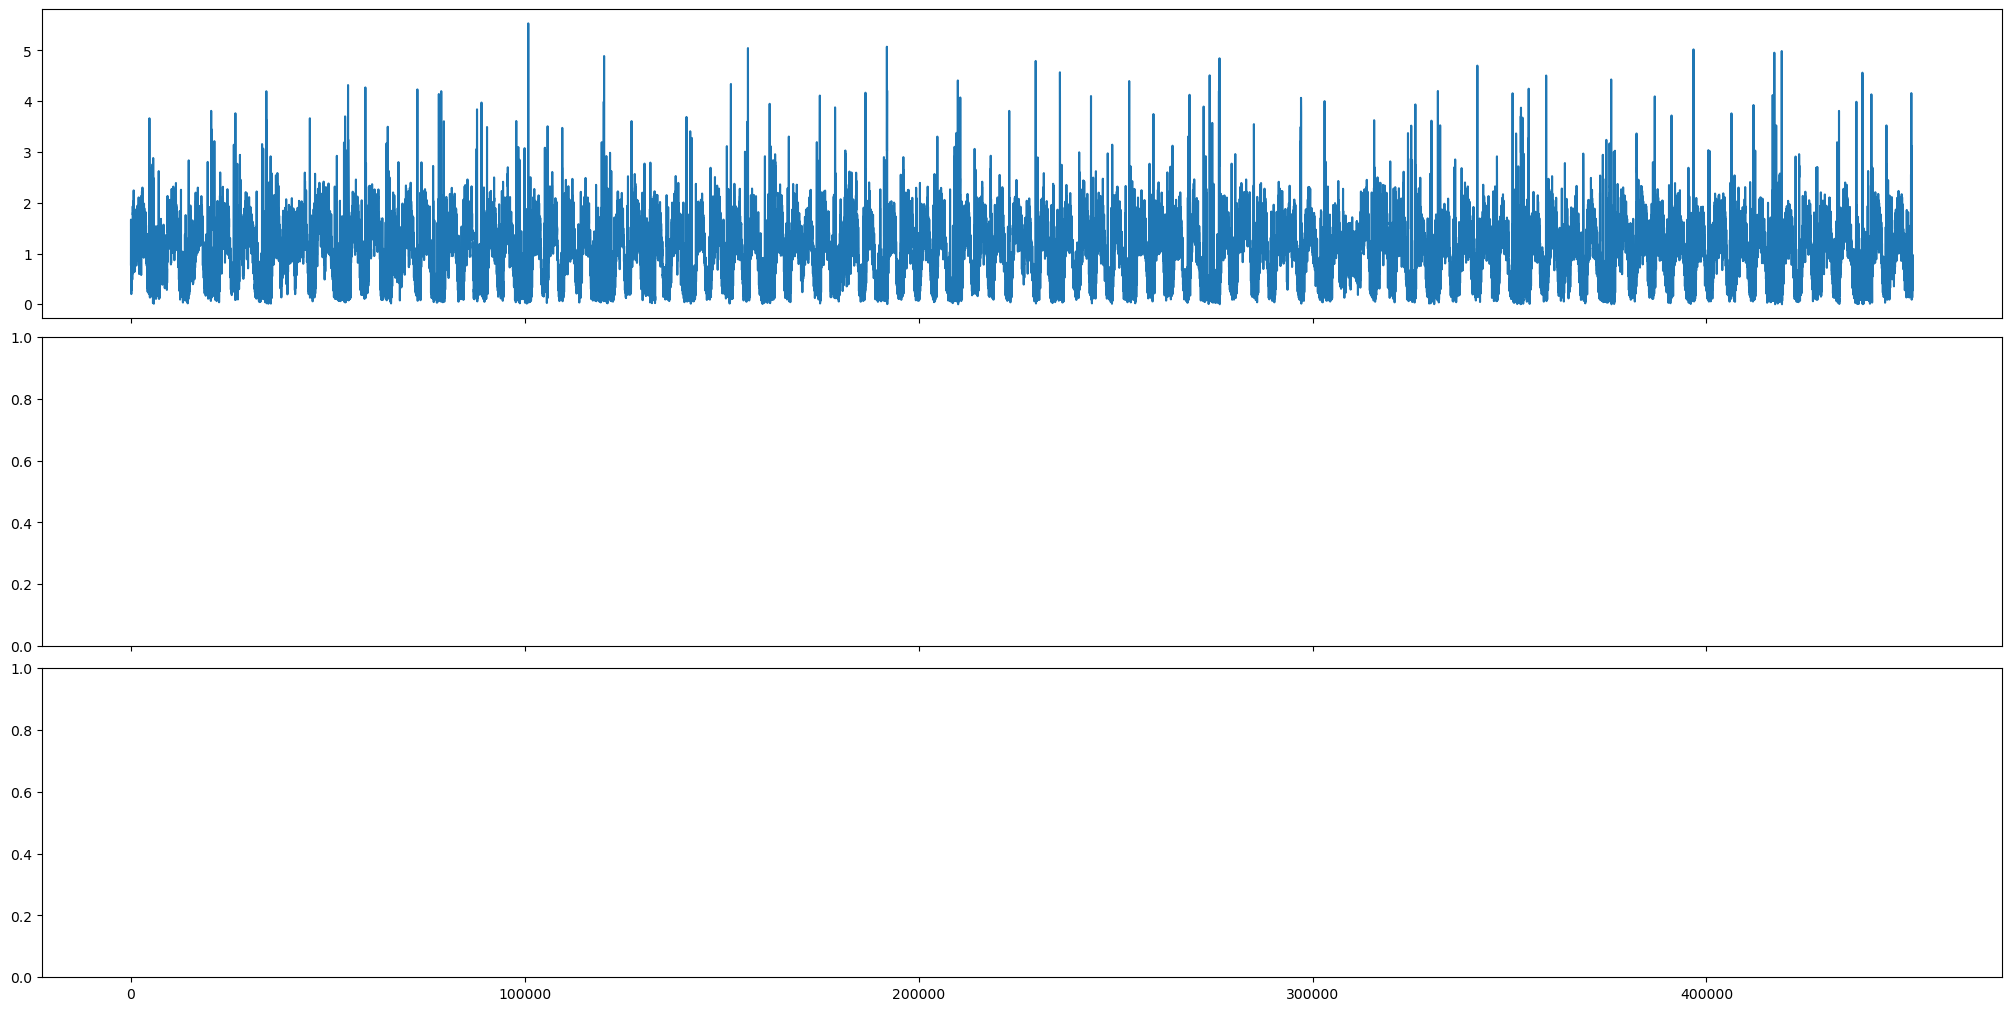

In [4]:
spike_rate = gaussian_smooth(spikes.sum(axis=1), sigma=sigma, sampling_frequency=500)

fig, axes = plt.subplots(3, 1, figsize=(20, 10), sharex=True, constrained_layout=True)
axes[0].plot(spike_rate)
axes[0].fill_between(
    np.arange(len(is_low_spike_time)),
    state_transition[:, 0, 0] * 10.0,
    color="yellow",
    alpha=0.1,
)
axes[0].fill_between(
    np.arange(len(is_low_spike_time)),
    state_transition[:, 1, 1] * 10.0,
    color="red",
    alpha=0.1,
)
axes[0].fill_between(
    np.arange(len(is_low_spike_time)),
    state_transition[:, 2, 2] * 10.0,
    color="green",
    alpha=0.1,
)


axes[1].plot(position, color="magenta")

axes[2].plot(speed, color="lightgrey")

plt.xlim((240_000, 250_000))


In [118]:
def estimate_initial_discrete_transition(
    is_ripple,
    spikes,
    speed,
    low_spike_rate_threshold=0.1,
    low_spike_smoothing_sigma=0.015,
    stationary=True,
    speed_knots=None,
):

    is_low_spike_time = estimate_low_spike_times(
        spikes,
        speed,
        rate_threshold=low_spike_rate_threshold,
        sigma=low_spike_smoothing_sigma,
    )
    is_local_time = np.logical_and(~is_ripple, ~is_low_spike_time)

    response = np.zeros_like(is_local_time, dtype=int)
    response[is_local_time] = 0
    response[is_low_spike_time] = 1
    response[is_ripple] = 2

    data = {
        "local": lagmat(is_local_time, maxlag=1),
        "no_spike": lagmat(is_low_spike_time, maxlag=1),
        "non_local": lagmat(is_ripple, maxlag=1),
        "speed": lagmat(speed, maxlag=1),
    }

    state_names = ["local", "no_spike", "non_local"]
    if speed_knots is None:
        speed_knots = [1.0, 2.0, 3.0, 10.0, 50.0, 75.0]

    n_states = len(state_names)
    n_time = spikes.shape[0]
    coef = []

    if stationary:
        state_transition = np.zeros((n_states, n_states))
        predict_matrix = np.array([1])[:, np.newaxis]
    else:
        state_transition = np.zeros((n_time, n_states, n_states))

    for state_ind, from_state in enumerate(state_names):
        if stationary:
            formula = f"{from_state} - 1"
        else:
            formula = (
                f"1 + {from_state} * "
                f"cr(speed, knots={speed_knots}, constraints='center')"
            )
        design_matrix = dmatrix(formula, data)
        model = LogisticRegression(fit_intercept=False).fit(design_matrix, response)

        if stationary:
            state_transition[state_ind, :] = model.predict_proba(
                predict_matrix
            ).squeeze()
        else:
            state_transition[:, state_ind, :] = model.predict_proba(
                design_matrix
            ).squeeze()

        coef.append(model.coef_.T)

    coef = np.stack(coef, axis=1)

    return state_transition, coef, design_matrix


In [46]:
from statsmodels.tsa.tsatools import lagmat
from patsy import dmatrix

low_spike_rate_threshold=0.1
low_spike_smoothing_sigma=0.015

data = {
    "local": lagmat(is_local_time, maxlag=1),
    "no_spike": lagmat(is_low_spike_time, maxlag=1),
    "non_local": lagmat(is_ripple, maxlag=1),
    "speed": lagmat(speed, maxlag=1),
}

state_names = ["local", "no_spike", "non_local"]

speed_knots = [1.0, 2.0, 3.0, 10.0, 50.0, 75.0]

n_states = len(state_names)
n_time = spikes.shape[0]
coef = []

is_low_spike_time = estimate_low_spike_times(
    spikes,
    speed,
    rate_threshold=low_spike_rate_threshold,
    sigma=low_spike_smoothing_sigma,
)
is_local_time = np.logical_and(~is_ripple, ~is_low_spike_time)

response = np.zeros_like(is_local_time, dtype=int)
response[is_local_time] = 0
response[is_low_spike_time] = 1
response[is_ripple] = 2

In [129]:
from sklearn.linear_model import LogisticRegression

from_state = "local"
formula = (
    f"bs(speed[{from_state} == 1], knots={speed_knots}) - 1"
)
design_matrix = dmatrix(formula, data)
model = LogisticRegression(fit_intercept=False, penalty='none', multi_class='multinomial').fit(design_matrix, response[data[from_state].squeeze().astype(bool)])
model.coef_.shape

(3, 9)

In [103]:
model.classes_

array([0, 1, 2])

In [137]:
from src.hmm import centered_softmax_forward

prob = centered_softmax_forward(design_matrix @ model.coef_[:-1].T)
prob

array([[1.00000000e+00, 6.43538294e-81, 4.63574863e-57],
       [1.00000000e+00, 1.50445742e-80, 1.01859921e-56],
       [1.00000000e+00, 3.50773264e-80, 2.22886867e-56],
       ...,
       [3.33333333e-01, 3.33333333e-01, 3.33333333e-01],
       [3.33333333e-01, 3.33333333e-01, 3.33333333e-01],
       [3.33333333e-01, 3.33333333e-01, 3.33333333e-01]])

In [131]:
model.coef_.shape

(3, 9)

In [132]:
prob

array([[1.38820792e-24, 3.33937631e-33, 1.00000000e+00],
       [1.47698663e-24, 6.89646873e-33, 1.00000000e+00],
       [1.57377269e-24, 1.41625832e-32, 1.00000000e+00],
       ...,
       [3.33333333e-01, 3.33333333e-01, 3.33333333e-01],
       [3.33333333e-01, 3.33333333e-01, 3.33333333e-01],
       [3.33333333e-01, 3.33333333e-01, 3.33333333e-01]])

In [140]:
sklearn_prob = model.predict_proba(design_matrix)

(0.0, 100000.0)

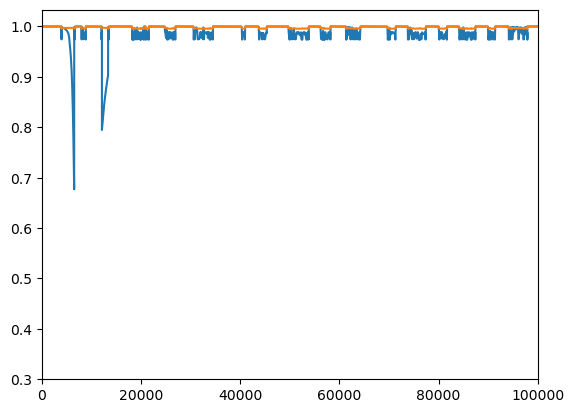

In [138]:
import matplotlib.pyplot as plt

plt.plot(prob[:, 0])
plt.plot(sklearn_prob[:, 0])

plt.xlim((0, 100_000))

In [53]:
sklearn_prob.shape

(433510, 3)

In [105]:
from statsmodels.discrete.discrete_model import MNLogit

from_state = "local"
formula = (
    f"bs(speed[{from_state} == 1], knots={speed_knots}) - 1"
)
design_matrix = dmatrix(formula, data)

model = MNLogit(response[data[from_state].squeeze().astype(bool)], design_matrix).fit(method="bfgs")
model

         Current function value: 0.015344
         Iterations: 35
         Function evaluations: 40
         Gradient evaluations: 40


/Users/edeno/miniconda3/envs/test_hmm/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [79]:
model.params.shape

(9, 2)

In [120]:
from scipy.special import softmax

def centered_softmax_forward(y):
    """`softmax(x) = exp(x-c) / sum(exp(x-c))` where c is the last coordinate

    Example
    -------
    > y = np.log([2, 3, 4])
    > np.allclose(centered_softmax_forward(y), [0.2, 0.3, 0.4, 0.1])
    """
    if y.ndim == 1:
        y = np.insert(y, 0, 0)
    else:
        y = np.column_stack((np.zeros((y.shape[0],)), y))

    return softmax(y, axis=-1)


prob = centered_softmax_forward((design_matrix @ model.params))

In [121]:
sm_prob = model.predict(design_matrix)

(0.0, 100000.0)

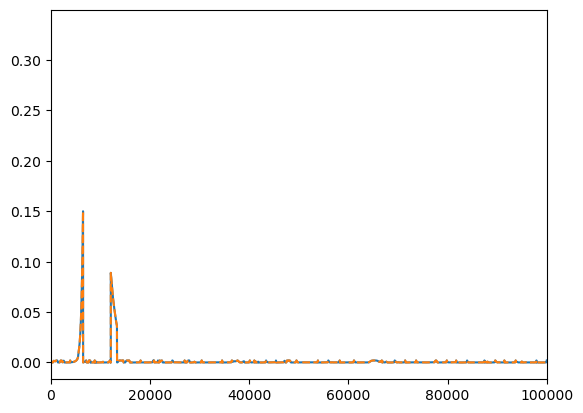

In [124]:

plt.plot(prob[:, 2])
plt.plot(sm_prob[:, 2], linestyle='--')

plt.xlim((0, 100_000))

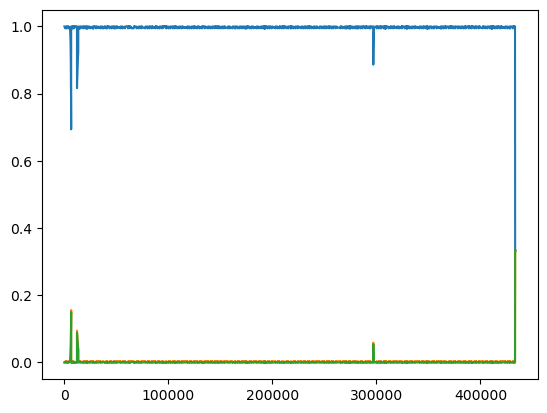

In [128]:
plt.plot(prob[:, 0])
plt.plot(prob[:, 1])
plt.plot(prob[:, 2])

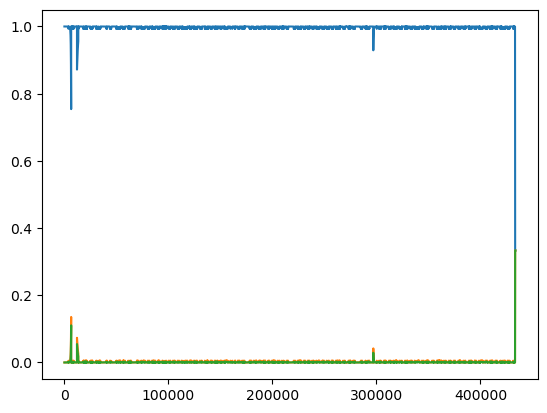

In [141]:
plt.plot(sklearn_prob[:, 0])
plt.plot(sklearn_prob[:, 1])
plt.plot(sklearn_prob[:, 2])

In [1]:
from src.test_non_local_switching_model import load_data

is_ripple, spikes, position, speed, env, time = load_data(work_computer=False)


In [32]:
from src.test_non_local_switching_non_stationary_model import estimate_no_spike_times, lagmat
from patsy import dmatrix
import numpy as np
from statsmodels.discrete.discrete_model import MNLogit
from sklearn.linear_model import LogisticRegression

low_spike_rate_threshold = 0.1
low_spike_smoothing_sigma = 0.015

is_no_spike_time = estimate_no_spike_times(
    spikes,
    speed,
    rate_threshold=low_spike_rate_threshold,
    sigma=low_spike_smoothing_sigma,
)
is_local_time = np.logical_and(~is_ripple, ~is_no_spike_time)

speed_knots = [1.0, 2.0, 3.0, 10.0, 50.0, 75.0]

data = {
    "local": is_local_time,
    "no_spike": is_no_spike_time,
    "non_local": is_ripple,
    "lagged_local": lagmat(is_local_time, maxlag=1),
    "lagged_no_spike": lagmat(is_no_spike_time, maxlag=1),
    "lagged_non_local": lagmat(is_ripple, maxlag=1),
    "lagged_speed": lagmat(speed, maxlag=1),
}

state_names = ["local", "no_spike", "non_local"]
formula = f"bs(lagged_speed, knots={speed_knots}) - 1"
design_matrix = dmatrix(formula, data)

n_states = len(state_names)
transition_coefficients = np.zeros((design_matrix.shape[1], n_states, n_states - 1))

for from_state_ind, from_state in enumerate(state_names):
    for to_state_ind, to_state in enumerate(state_names[:-1]):
        is_from_state = data[f"lagged_{from_state}"].astype(bool).squeeze()
        dm = design_matrix[is_from_state]
        response = data[to_state][is_from_state]
        transition_coefficients[:, from_state_ind, to_state_ind] = LogisticRegression().fit(dm, response).coef_.squeeze()

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: False

In [34]:
from_state, to_state

('non_local', 'no_spike')

In [23]:
design_matrix.shape

(452325, 9)

In [24]:
is_from_state.shape

(452325,)

In [25]:
data[to_state].shape

(452325,)

In [27]:
design_matrix[is_from_state].shape

(433510, 9)

In [28]:
response.shape

(433510,)

In [31]:
response

array([False, False, False, ..., False, False, False])